# Fidelity plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pathlib
import plotly.graph_objects as go

In [2]:
"""UNZIP ROUTINE"""

def unzip_data_npz(root_dir, output_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'data.npz' in filenames:
            npz_path = os.path.join(dirpath, 'data.npz')
            
            # Create a subdirectory in the output directory that mirrors the original structure
            relative_path = os.path.relpath(dirpath, root_dir)
            data_dir = os.path.join(output_dir, relative_path, 'data')
            
            if not os.path.exists(data_dir):
                try:
                    with np.load(npz_path, allow_pickle=True) as data:
                        os.makedirs(data_dir, exist_ok=True)
                        for key, value in data.items():
                            np.save(os.path.join(data_dir, f"{key}.npy"), value)
                except Exception as e:
                    print(f"Error unzipping {npz_path}: {str(e)}")

In [3]:
root_directory = os.path.join(os.getcwd(), 'rb_opt_3h')
output_directory = os.path.join(os.getcwd(), 'unzipped_data')
print(root_directory)

/home/elisa/Desktop/Qibo/Qibocal/optimization/rb_opt_3h


In [4]:
path = os.path.join(root_directory,'data/')

rb_paths = [item for item in os.listdir(path) if item.startswith('rb_ondevice') 
            and os.path.isdir(os.path.join(path, item))]
sorted_rb_items = sorted(rb_paths, key=lambda x: int(x.split('-')[1]))
print(len(sorted_rb_items))

all_decay_params, all_decay_errs = [], []
for rbpath in sorted_rb_items:
    with open(f"{path}{rbpath}/results.json") as f:
        data_dict = json.load(f)
    popt = data_dict['"pars"']['"D1"']
    pcov = np.array(data_dict['"cov"']['"D1"']).reshape(3,3)
    perr = np.sqrt(np.diag(pcov))
    all_decay_params.append(popt[2])
    all_decay_errs.append(perr[2])

all_decay_params, all_decay_errs = np.array(all_decay_params), np.array(all_decay_errs)

259


In [5]:
infidelity = (1 - all_decay_params) / 2
pulse_fidelities = 1 - infidelity / 1.875

pulse_fidelities_err = all_decay_errs / (1.875 * 2)

In [6]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.arange(len(all_decay_params)),  
    y=all_decay_params,  
    error_y=dict(
        type='data',  # Use 'data' for error values provided directly
        array=all_decay_errs,  # Error array
        visible=True  # Show error bars
    ),
    mode='markers+lines',  
    name='Decay Parameters'
))

fig.update_layout(
    title='Fidelity optimization',
    xaxis_title='Optimization step',
    yaxis_title='Fidelity',
    hovermode='closest',  
)

fig.show()
fig.write_html("optimization_no_beta.html")
fig.write_html("optimization_no_beta.ong")

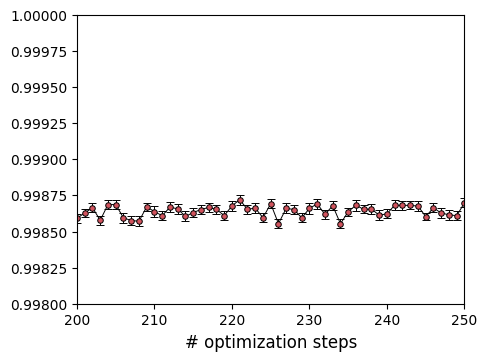

In [11]:
x = np.arange(1, len(pulse_fidelities) + 1)

fig, ax1 = plt.subplots(1, figsize=(WIDTH * 10 , WIDTH * 10 * 6/8))
ax1.errorbar(x, pulse_fidelities, yerr=pulse_fidelities_err, fmt='o', linestyle='none', markersize=4, color="black", 
             markerfacecolor=RED, ecolor="black", markeredgewidth=0.7, elinewidth=0.7, alpha=1, label=r"qubit 1", capsize=3)
ax1.plot(x, pulse_fidelities, '-', color='black', linewidth=0.7)

# Set the x-axis limit to zoom in on the range between 200 and 250
ax1.set_xlim(200, 250)
ax1.set_ylim(0.998, 1.000)

# Label the axes
ax1.set_xlabel('# optimization steps', fontsize=12)
# ax1.set_ylabel(r'$\pi/2$ fidelity', fontsize=12)

# Save the figure
plt.savefig(f'plot_zoomed', bbox_inches="tight", dpi=600)